# Converting Downscaled ERA5 files

### Initial libs

In [1]:
import warnings
warnings.filterwarnings("ignore")
import sys,getopt
import pandas as pd;import numpy as np
import pathlib as pl
import numpy.core.multiarray 
import netCDF4 as nc4;import xarray as xr
import scipy.interpolate
import datetime
from pyproj import Proj, transform,Transformer
import matplotlib.pyplot as plt;
import matplotlib as mpl;
import cartopy as cart
import cartopy.crs as ccrs
import wrf
from wrf import PolarStereographic
from pyproj.crs import BoundCRS, Ellipsoid, GeographicCRS, ProjectedCRS
import geopandas as gpd;import shapely as shape
import boto3; import os

In [2]:
s3 = boto3.client("s3")
s3_resource = boto3.resource('s3')
bucket_name = 'wrf-ak-ar5'
direct1 = s3.list_objects_v2(Bucket=bucket_name,Delimiter='/',MaxKeys=1000)

In [3]:
prefix = direct1['CommonPrefixes'][1]['Prefix']
direct2 = s3.list_objects_v2(Bucket=bucket_name,Prefix=prefix,Delimiter='/',MaxKeys=1000)
directory = 'u10/'
prefix = direct2['CommonPrefixes'][0]['Prefix']+'historical/'+directory
direct3 = s3.list_objects_v2(Bucket=bucket_name,Prefix=prefix,Delimiter='/',MaxKeys=1000)

In [6]:
directory = ['seaice/']#['u10/','v10/']
for d in directory:
    prefix = direct2['CommonPrefixes'][0]['Prefix']+'historical/'+d
    direct3 = s3.list_objects_v2(Bucket=bucket_name,Prefix=prefix,Delimiter='/',MaxKeys=1000)
    outpath = pl.Path('/Users/tmiesse/work/FHRL/arctic/climate_data/era_interim')
    for contents in direct3['Contents']:
        name = contents['Key'].split('/')[4]
        file = contents['Key']
        ofile= outpath/ 'sea_ice' /name
        s3.download_file(Bucket=bucket_name,Key=file,Filename=ofile)

functions

In [2]:
def compute_error(wrf_proj, xx, yy):
    wgs_proj = Proj(proj='latlong', datum='WGS84')
    transformer = Transformer.from_proj(wrf_proj, wgs_proj)
    our_lons, our_lats = transformer.transform(xx, yy)
    error_arr = np.sqrt((our_lons - geo_ds.XLONG_M)**2 + (our_lats - geo_ds.XLAT_M)**2)
    
    return error_arr.values[0]

In [3]:
def compute_grid(wrf_proj, geo_ds):
    wgs_proj = Proj(proj='latlong', datum='WGS84')
    transformer = Transformer.from_proj(wgs_proj, wrf_proj)

    # Easting and Northings of the domains center point
    e, n = transformer.transform(geo_ds.CEN_LON, geo_ds.CEN_LAT)
    # Grid parameters
    dx, dy = geo_ds.DX, geo_ds.DY
    nx, ny = geo_ds.dims['west_east'], geo_ds.dims['south_north']
    # Down left corner of the domain
    x0 = -(nx-1) / 2. * dx + e
    y0 = -(ny-1) / 2. * dy + n
    # 2d grid
    xx, yy = np.meshgrid(np.arange(nx) * dx + x0, np.arange(ny) * dy + y0)
    
    return xx, yy

#### Initialize files and paths

In [4]:
path = pl.Path('/Users/tmiesse/work/FHRL/arctic/climate_data/era_interim')
files = list((path / 'pressure').glob('*'))
#file = 'seaice_hourly_wrf_ERA-Interim_historical_1979.nc'

wrf_ds = xr.open_dataset(files[0])
geo_ds = xr.open_dataset(path / 'geo_em.d01.nc' )
geo_ds.attrs["MAP_PROJ"]

2

In [5]:
wrf_proj = Proj(
    proj="lcc", # projection type: Lambert Conformal Conic
    lat_1=geo_ds.TRUELAT1, lat_2=geo_ds.TRUELAT2, # Cone intersects with the sphere
    lat_0=geo_ds.MOAD_CEN_LAT, lon_0=geo_ds.STAND_LON, # Center point
    a=6370000, b=6370000 # This is it! The Earth is a perfect sphere
) 
# WGS 
wgs_proj = Proj(proj='latlong', datum='WGS84')

In [6]:
xx, yy = compute_grid(wrf_proj, geo_ds)

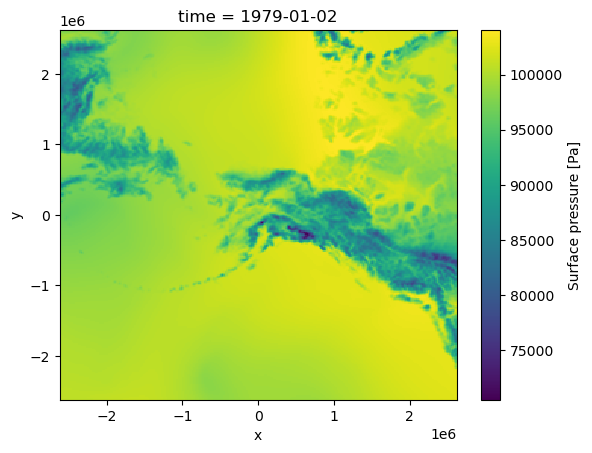

In [7]:
new_ds = wrf_ds.rename_dims({"yc": "y", "xc": "x"})
new_ds = new_ds.assign_coords({"y": ("y", yy[::-1,0]), "x": ("x", xx[0,:])})
new_ds.psfc[0].plot()

In [8]:
wrf_vars = ["TRUELAT1", "TRUELAT2", "MOAD_CEN_LAT", "STAND_LON", "POLE_LAT", "POLE_LON"]
wrf_proj_str = PolarStereographic(**{var: geo_ds.attrs[var] for var in wrf_vars}).proj4()
wrf_proj = Proj(wrf_proj_str)
xx, yy = compute_grid(wrf_proj, geo_ds)
error_arr = compute_error(wrf_proj, xx, yy)


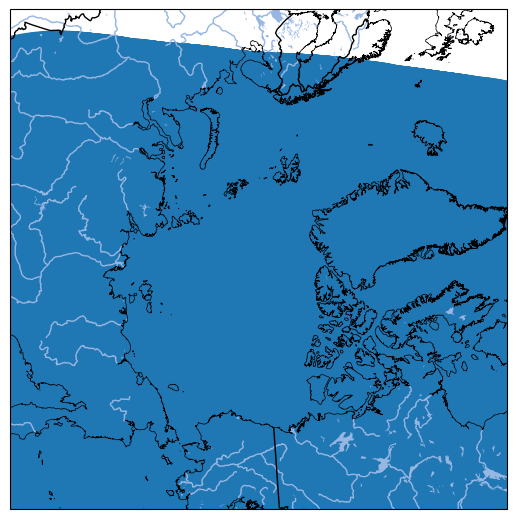

In [9]:

inProj = Proj(wrf_proj_str)
outProj = Proj(init='epsg:4326')

x2,y2 = transform(inProj,outProj,xx,yy[::-1])

data = wrf_ds['psfc'][0,:,:]


# map boundary ------------------------------------------------------------------------
lat1,lat2 = 60,85
lon1,lon2 = -180,180

# -------------------------------------------------------------------------------------
plt.rcParams["font.family"] = "Times New Roman"
cmap = mpl.cm.get_cmap('cool')

fig = plt.figure(figsize=(6,5))
proj = ccrs.NorthPolarStereo(central_longitude=-145)
#tiler = cart_img.GoogleTiles('terrain-background')

ax = plt.axes([0,0,1.,1.],projection=proj)
cmap = mpl.cm.get_cmap('jet')
fig.tight_layout(pad=0.75)
levels = np.arange(0,1,0.1)

# Initialize data for map

ax.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax.coastlines(resolution='10m',linewidth=0.5)
ax.add_feature(cart.feature.LAKES)
ax.add_feature(cart.feature.RIVERS, linestyle="-")
ax.add_feature(cart.feature.BORDERS.with_scale("50m"), linestyle="-")


ax.scatter(x2,y2,data.data,transform = ccrs.PlateCarree(),vmin=np.min(data), vmax=np.max(data),cmap=cmap)

# subplot adjustment -----------------------------------------------------------


plt.show(fig)

In [12]:
shape = gpd.GeoDataFrame({'track':[],'month':[],'year':[]})


In [16]:
time = wrf_ds['time'][:]
for t in range(0,len(time[:1])):
    idx = np.where(np.min(wrf_ds['psfc'][t,:,:]))[0]

In [17]:
idx

array([0])

In [14]:
wrf_ds

<xarray.Dataset>
Dimensions:  (time: 8736, yc: 262, xc: 262)
Coordinates:
  * xc       (xc) float64 -2.61e+06 -2.59e+06 -2.57e+06 ... 2.59e+06 2.61e+06
  * time     (time) datetime64[ns] 1979-01-02 ... 1979-12-31T23:00:00
  * yc       (yc) float64 -1.824e+05 -2.024e+05 ... -5.382e+06 -5.402e+06
Data variables:
    psfc     (time, yc, xc) float32 ...
Attributes:
    creation_date:    Mon Nov 25 10:32:57 AKST 2013
    NCL_Version:      6.1.2
    system:           Linux pacman1 2.6.32-358.14.1.el6.x86_64 #1 SMP Mon Jun...
    Conventions:      None
    grib_source:      WRFDS_d01.1979-01-02_00.grib
    title:            NCL: convert-GRIB-to-netCDF
    reference_time:   1979-01-02 00:00:00
    proj_parameters:  +units=m +proj=stere +lat_ts=64.0 +lon_0=-152.0 +lat_0=...
    SNAP_VERSION:     1.0
    restacked_by:     Scenarios Network for Alaska + Arctic Planning -- 2018
    crs_wkt:          PROJCS["unnamed",GEOGCS["unnamed ellipse",DATUM["unknow...

In [19]:
data.data

array([[0.       , 0.       , 0.       , ..., 0.8515625, 0.8515625,
        0.8515625],
       [0.       , 0.       , 0.       , ..., 0.8671875, 0.8671875,
        0.859375 ],
       [0.       , 0.       , 0.       , ..., 0.875    , 0.875    ,
        0.875    ],
       ...,
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ]], dtype=float32)